<a href="https://colab.research.google.com/github/anujpanwarma2024/RLMidTermProject/blob/main/RLEndTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Load with row 6 as header
url = (
    "https://raw.githubusercontent.com/"
    "anujpanwarma2024/RLMidTermProject/main/"
    "Clean%20Untitled%20spreadsheet%20-%20Data%20Tape.csv"
)
df = pd.read_csv(url, skiprows=5)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Extract interest rate % from Loan Product
df['InterestRatePct'] = (
    df['Loan Product'].astype(str)
      .str.extract(r'(\d+\.?\d*)%\s*$', expand=False)
      .astype(float)
)

# Parse DTI
df['Qualifying DTI'] = pd.to_numeric(df['Qualifying DTI'].astype(str).str.rstrip('%'), errors='coerce')

# Coerce and drop
for col in ['DPD', 'Loan Age', 'Original Loan Amount', 'Current Outstanding Principal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['InterestRatePct','Qualifying DTI','DPD','Loan Age'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Context helper
def extract_context(row):
    return np.array([row['InterestRatePct'], row['DPD'], row['Loan Age']], dtype=np.float32)

print("Phase 1 ready, rows:", len(df))


Phase 1 ready, rows: 240


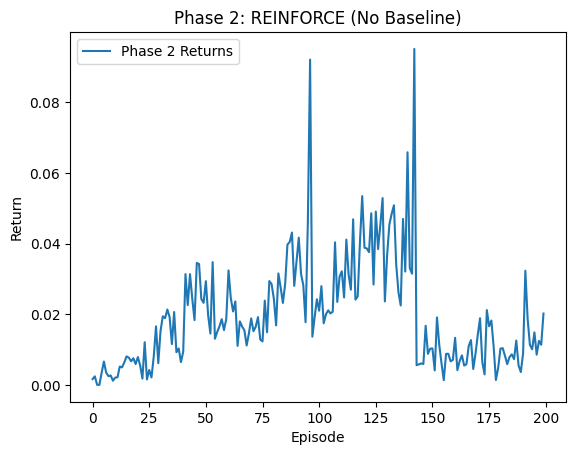

Phase 2 Mean Return: 0.020


In [3]:
# === Phase 2: Base Continuous REINFORCE ===

import numpy as np
import matplotlib.pyplot as plt

# (Re‐use df and extract_context from Phase 1 setup)

# Hyperparameters
num_episodes = 200
alpha = 0.01      # learning rate
sigma = 0.1       # policy std‐dev

# Initialize policy weights
w2 = np.zeros(3, dtype=np.float32)

# Storage for episode returns
returns2 = []

for ep in range(num_episodes):
    xs, actions, rewards = [], [], []

    # Sample an initial loan and context
    row = df.sample(1).iloc[0]
    x = extract_context(row)

    # Rollout one episode (4 steps/quarters)
    for t in range(4):
        mu = w2.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)

        # Compute reward = allocation × interest rate
        r = a * (row['InterestRatePct'] / 100.0)

        xs.append(x)
        actions.append(a)
        rewards.append(r)

        # Move to next loan/context
        row = df.sample(1).iloc[0]
        x = extract_context(row)

    # Monte Carlo return
    G = sum(rewards)
    returns2.append(G)

    # REINFORCE update
    for x_t, a_t in zip(xs, actions):
        grad_logp = ((a_t - w2.dot(x_t)) / sigma**2) * x_t
        w2 += alpha * G * grad_logp

# Plot Phase 2 learning curve
plt.plot(returns2, label='Phase 2 Returns')
plt.title("Phase 2: REINFORCE (No Baseline)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

print(f"Phase 2 Mean Return: {np.mean(returns2):.3f}")


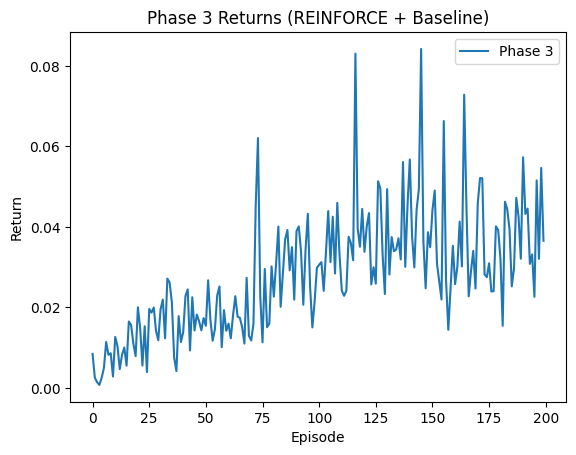

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
num_episodes = 200
alpha = 0.01
sigma = 0.1
beta = 0.1

# Initialize
w3 = np.zeros(3, dtype=np.float32)
b3 = 0.0
returns3 = []

# Phase 3 loop
for ep in range(num_episodes):
    xs, acts, rs = [], [], []
    row = df.sample(1).iloc[0]
    x = extract_context(row)
    for t in range(4):
        mu = w3.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)
        # Reward only (no punishment)
        r = a * (row['InterestRatePct']/100.0)
        xs.append(x); acts.append(a); rs.append(r)
        row = df.sample(1).iloc[0]
        x = extract_context(row)
    G = sum(rs)
    returns3.append(G)
    A = G - b3
    for x_t, a_t in zip(xs, acts):
        grad_logp = ((a_t - w3.dot(x_t)) / sigma**2) * x_t
        w3 += alpha * A * grad_logp
    b3 = (1 - beta) * b3 + beta * G

# Plot
plt.plot(returns3, label='Phase 3')
plt.title("Phase 3 Returns (REINFORCE + Baseline)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()
plt.show()


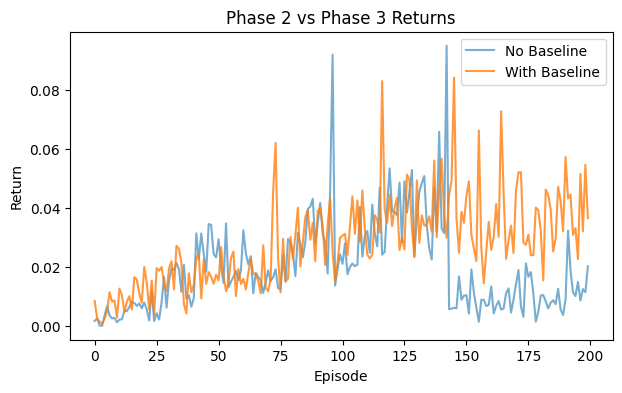

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(returns2, label='No Baseline', alpha=0.6)
plt.plot(returns3, label='With Baseline', alpha=0.8)
plt.title("Phase 2 vs Phase 3 Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


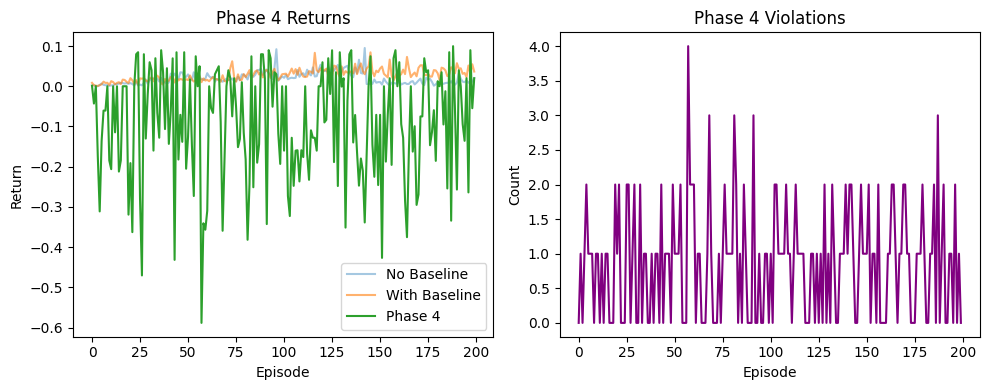

Phase 4 Mean Return:     -0.094
Phase 4 Mean Violations: 0.86


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
num_episodes = 200
alpha = 0.01        # policy LR
sigma = 0.1         # policy noise
beta  = 0.1         # baseline LR
P     = 0.005       # smaller base penalty
DTI_THRESHOLD = 0.20

def step4(x, a, row):
    # Base reward = allocation × interest rate
    reward = a * (row['InterestRatePct']/100.0)
    # Proportional penalty
    dti = row['Qualifying DTI']
    if dti > DTI_THRESHOLD:
        reward -= P * (dti - DTI_THRESHOLD)
        vio = True
    else:
        vio = False
    next_row = df.sample(1).iloc[0]
    return extract_context(next_row), reward, vio

# Initialize
w4 = np.zeros(3, dtype=np.float32)
b4 = 0.0
returns4, violations4 = [], []

# Training
for ep in range(num_episodes):
    xs, acts, rs = [], [], []
    vio_cnt = 0
    row = df.sample(1).iloc[0]
    x = extract_context(row)
    for t in range(4):
        mu = w4.dot(x)
        a  = np.clip(np.random.normal(mu, sigma), 0, 1)
        x, r, vio = step4(x, a, row)
        xs.append(x); acts.append(a); rs.append(r)
        vio_cnt += int(vio)
        row = df.sample(1).iloc[0]
    G = sum(rs)
    returns4.append(G)
    violations4.append(vio_cnt)
    A = G - b4
    for x_t, a_t in zip(xs, acts):
        grad_logp = ((a_t - w4.dot(x_t)) / sigma**2) * x_t
        w4 += alpha * A * grad_logp
    b4 = (1 - beta) * b4 + beta * G

# Plot Phase 4
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(returns2, alpha=0.4, label='No Baseline')
plt.plot(returns3, alpha=0.6, label='With Baseline')
plt.plot(returns4,       label='Phase 4')
plt.title("Phase 4 Returns")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()
plt.subplot(1,2,2)
plt.plot(violations4, color='purple')
plt.title("Phase 4 Violations")
plt.xlabel("Episode"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Phase 4 Mean Return:     {np.mean(returns4):.3f}")
print(f"Phase 4 Mean Violations: {np.mean(violations4):.2f}")


IPS Estimate: 0.0000


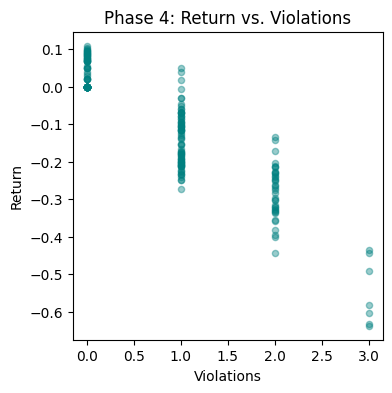

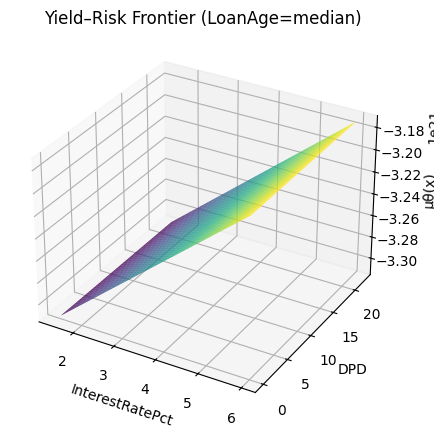

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1) IPS Estimate
n_eval = min(1000, len(df))
df_eval = df.sample(n_eval, replace=True, random_state=0)
ips_vals = []
for _, row in df_eval.iterrows():
    x     = extract_context(row)
    a_log = np.random.rand()
    r     = a_log * (row['InterestRatePct']/100.0)
    mu    = w4.dot(x)
    p_t   = norm.pdf(a_log, loc=mu, scale=sigma)
    p_t   = max(p_t, 1e-8)
    ips_vals.append(r * p_t)
print(f"IPS Estimate: {np.mean(ips_vals):.4f}")

# 2) Return vs. Violations (first 200)
plt.figure(figsize=(4,4))
plt.scatter(violations4, returns4, alpha=0.4, s=20, color='teal')
plt.title("Phase 4: Return vs. Violations")
plt.xlabel("Violations"); plt.ylabel("Return")
plt.show()

# 3) Yield–Risk Frontier
grid = 50
irp = np.linspace(df['InterestRatePct'].min(), df['InterestRatePct'].max(), grid)
dpd = np.linspace(df['DPD'].min(), df['DPD'].max(), grid)
LA_med = df['Loan Age'].median()
IR, D = np.meshgrid(irp, dpd)
MU = np.zeros_like(IR, dtype=np.float32)

for i in range(grid):
    for j in range(grid):
        x = np.array([IR[i,j], D[i,j], LA_med], dtype=np.float32)
        MU[i,j] = w4.dot(x)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(IR, D, MU, cmap='viridis', edgecolor='none')
ax.set_title("Yield–Risk Frontier (LoanAge=median)")
ax.set_xlabel("InterestRatePct"); ax.set_ylabel("DPD"); ax.set_zlabel("μθ(x)")
plt.show()
